# Create a cell (function for calculating the DGSLR index from the input datat)

In [29]:
import numpy as np

from scipy import interp
import matplotlib.pyplot as plt
from itertools import cycle

# the module for the roc_curve value
from sklearn.metrics import *

# Config the matlotlib backend as plotting inline in IPython
%matplotlib inline

In [30]:
# function for DGLSR index calculation
def calculateDGLSR(data):
    ''' 
        function for calculating the DGLSR index
        @Params
        data = the numpy array for the input data
        
        @Return 
        calculated DGLSR index for the input data
    '''
    
    # The following weights array was derived by using the AHP process for determining
    # the influencing parameters
    weights_array = np.array([
        3.00, # drainage density Very high
        2.40, # --===----        High
        1.80, # --===----        Moderate
        1.20, # --===----        Low
        0.60, # --===----        Very Low
        6.60, # Geology          Diveghat Formation
        5.40, # --===----        Purandargarh formation 
        4.75, # Slope            Very Steep
        4.07, # --===----        Mod. Steep
        3.39, # --===----        Strong
        2.72, # --===----        Mod. Strong
        2.03, # --===----        Gentle
        1.36, # --===----        Very Gentle
        0.68, # --===----        Nearly level
        4.40, # Landform classi  Plateau surface remnants
        3.30, # --===----        Plateau fringe surface
        2.20, # --===----        Buried Pediment
        1.10, # --===----        Rolling Piedmont Plain
        4.67, # Landuse/land cov Waste Land
        3.73, # --===----        Forest/vegetation
        2.80, # --===----        Agriculture Land
        1.87, # --===----        Water Bodies
        0.93, # --===----        Built-up land
        8.33, # Rainfall         < 900mm
        6.67, # --===----        900mm - 975mm
        5.00, # --===----        975mm - 1050mm
        3.33, # --===----        1050mm - 1100mm
        1.67, # --===----        > 1100mm
        3.33, # Runoff           Very High
        2.67, # --===----        High
        2.00, # --===----        Moderate
        1.33, # --===----        Low
        0.67  # --===----        Very Low
    ])
    
    print data.shape, weights_array.shape
    
    return np.sum(data * weights_array) / 100 # formula for calculating the DGSLR index

In [31]:
# test for the Subwater shed 1
calculateDGLSR(np.array([
    81.05,
    11.17,
    6.33,
    1.44,
    0.00,
    48.26,
    51.74,
    1.81,
    9.30,
    15.31,
    21.88,
    11.10,
    25.74,
    14.87,
    16.52,
    59.98,
    23.50,
    0.00,
    39.44,
    51.41,
    6.44,
    0.06,
    2.65,
    0.00,
    0.00,
    20.07,
    56.83,
    23.10,
    5.28,
    31.65,
    18.57,
    4.40,
    40.10
]))

(33,) (33,)


23.254985999999999

# The CSV File now contains some historical facts related to the ground water level fluctuation. This can be used for validating the DGSLR model using ROC based validation.

In [32]:
# read the csv file into a numpy array.
validation_data = np.genfromtxt('../data/validation.csv', delimiter='\t', skip_header=1)

print validation_data.shape # to print the shape of the numpy array
validation_data[:] # print the first 10 values of the data

(33, 5)


array([[  1.        ,  73.85205556,  18.35516667,   6.77      ,  29.45      ],
       [  2.        ,  73.84816667,  18.37677778,   8.52      ,  30.01      ],
       [  3.        ,  73.85508333,  18.36997222,   7.87      ,  29.9       ],
       [  4.        ,  73.85572222,  18.37038889,   6.64      ,  30.1       ],
       [  5.        ,  73.85594444,  18.36497222,   8.47      ,  29.85      ],
       [  6.        ,  73.84908333,  18.34755556,   6.73      ,  28.8       ],
       [  7.        ,  73.83972222,  18.34191667,   6.2       ,  28.78      ],
       [  8.        ,  73.82127778,  18.35013889,   6.04      ,  29.34      ],
       [  9.        ,  73.81305556,  18.35969444,   9.29      ,  29.38      ],
       [ 10.        ,  73.81455556,  18.37458333,   8.83      ,  29.4       ],
       [ 11.        ,  73.80511111,  18.34444444,   7.77      ,  29.15      ],
       [ 12.        ,  73.78991667,  18.36230556,   5.42      ,  29.1       ],
       [ 13.        ,  73.78436111,  18.34491667,   

# now we transform this array into one hot encoded values.
# such that first array has the predicted class and second array has the ground truth/ actual class

In [33]:
# function to produce a class for the water-level fluctuation (aka. the actual class)
def actual_class(value):
    ''' 
        function to give the priority class for the water-level fluctuation
        @Param:
        value = the water level fluctuation value
        
        @Return
        the numerical class for the value.
    '''
    # the implementation is a simply condition ladder of the values given in the excel file.
    if(value <= 3.07):
        return 0 # priority is low
    elif(value > 3.07 and value <= 5.20):
        return 1 # priority is moderate
    elif(value > 5.20 and value <= 7.77):
        return 2 # priority is high
    else:
        return 3 # priority is very high


In [34]:
# function to produce a class for the DGSLR index value (aka. the predicted class)
def predicted_class(index):
    ''' 
        function to give the priority class for the DGLSR index value
        @Param:
        value = the DGLSR index so calcuated
        
        @Return
        the numerical class for the value.
    '''
    # the implementation is a simply condition ladder of the values given in the excel file.
    if(index <= 28.02):
        return 0 # priority is low
    elif(index > 28.02 and index <= 28.72):
        return 1 # priority is moderate
    elif(index > 28.72 and index <= 29.42):
        return 2 # priority is high
    else:
        return 3 # priority is very high
    

In [35]:
# number of classes is 4, so:
n_classes = 4

In [36]:
# initialize the two arrays to zero values
predictions = np.zeros(shape=(validation_data.shape[0], n_classes))
actual_values = np.zeros(shape=(validation_data.shape[0], n_classes))

(predictions[:3], actual_values[:3])

(array([[ 0.,  0.,  0.,  0.],
        [ 0.,  0.,  0.,  0.],
        [ 0.,  0.,  0.,  0.]]), array([[ 0.,  0.,  0.,  0.],
        [ 0.,  0.,  0.,  0.],
        [ 0.,  0.,  0.,  0.]]))

In [37]:
# loop through the validation_data and populate the predictions and the actual_values
for i in range(validation_data.shape[0]):
    predictions[i, predicted_class(validation_data[i, 4])] = 1
    actual_values[i, actual_class(validation_data[i, 3])] = 1

In [38]:
# print the predictions
predictions

array([[ 0.,  0.,  0.,  1.],
       [ 0.,  0.,  0.,  1.],
       [ 0.,  0.,  0.,  1.],
       [ 0.,  0.,  0.,  1.],
       [ 0.,  0.,  0.,  1.],
       [ 0.,  0.,  1.,  0.],
       [ 0.,  0.,  1.,  0.],
       [ 0.,  0.,  1.,  0.],
       [ 0.,  0.,  1.,  0.],
       [ 0.,  0.,  1.,  0.],
       [ 0.,  0.,  1.,  0.],
       [ 0.,  0.,  1.,  0.],
       [ 0.,  0.,  1.,  0.],
       [ 0.,  0.,  1.,  0.],
       [ 0.,  0.,  1.,  0.],
       [ 0.,  0.,  1.,  0.],
       [ 0.,  0.,  1.,  0.],
       [ 0.,  0.,  1.,  0.],
       [ 0.,  0.,  1.,  0.],
       [ 0.,  0.,  1.,  0.],
       [ 1.,  0.,  0.,  0.],
       [ 0.,  1.,  0.,  0.],
       [ 0.,  0.,  1.,  0.],
       [ 0.,  1.,  0.,  0.],
       [ 0.,  1.,  0.,  0.],
       [ 1.,  0.,  0.,  0.],
       [ 1.,  0.,  0.,  0.],
       [ 1.,  0.,  0.,  0.],
       [ 1.,  0.,  0.,  0.],
       [ 1.,  0.,  0.,  0.],
       [ 0.,  0.,  0.,  1.],
       [ 0.,  1.,  0.,  0.],
       [ 0.,  0.,  1.,  0.]])

In [39]:
# print the actual classes:
actual_values

array([[ 0.,  0.,  1.,  0.],
       [ 0.,  0.,  0.,  1.],
       [ 0.,  0.,  0.,  1.],
       [ 0.,  0.,  1.,  0.],
       [ 0.,  0.,  0.,  1.],
       [ 0.,  0.,  1.,  0.],
       [ 0.,  0.,  1.,  0.],
       [ 0.,  0.,  1.,  0.],
       [ 0.,  0.,  0.,  1.],
       [ 0.,  0.,  0.,  1.],
       [ 0.,  0.,  1.,  0.],
       [ 0.,  0.,  1.,  0.],
       [ 0.,  1.,  0.,  0.],
       [ 0.,  0.,  1.,  0.],
       [ 0.,  0.,  1.,  0.],
       [ 0.,  0.,  0.,  1.],
       [ 0.,  1.,  0.,  0.],
       [ 0.,  0.,  0.,  1.],
       [ 1.,  0.,  0.,  0.],
       [ 0.,  1.,  0.,  0.],
       [ 1.,  0.,  0.,  0.],
       [ 0.,  0.,  0.,  1.],
       [ 0.,  0.,  1.,  0.],
       [ 0.,  1.,  0.,  0.],
       [ 0.,  1.,  0.,  0.],
       [ 1.,  0.,  0.,  0.],
       [ 1.,  0.,  0.,  0.],
       [ 1.,  0.,  0.,  0.],
       [ 1.,  0.,  0.,  0.],
       [ 1.,  0.,  0.,  0.],
       [ 0.,  0.,  0.,  1.],
       [ 0.,  1.,  0.,  0.],
       [ 0.,  0.,  1.,  0.]])

In [44]:
# define the reverse label mappings for better visual representation:
reverse_labels_mappings = {
    0: "Low priority",
    1: "Moderate priority",
    2: "High priority",
    3: "Very high priority"
}

In [45]:
# now time to calculate the ROC_auc and generate the curve plots.

# first generate the curves as follows
# Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(actual_values[:, i], predictions[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

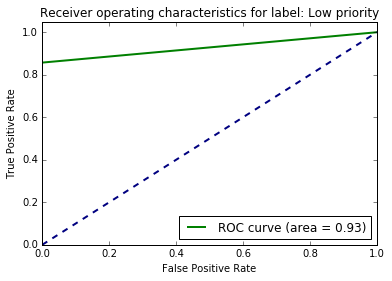

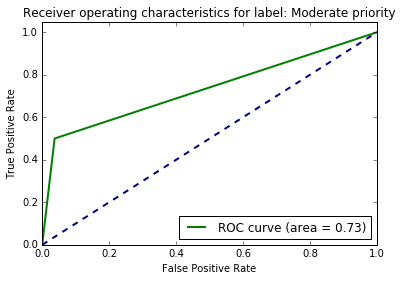

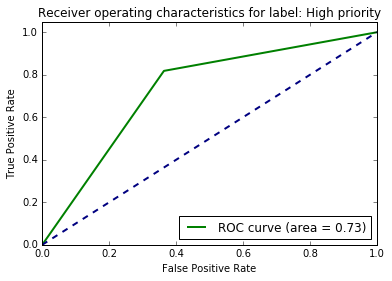

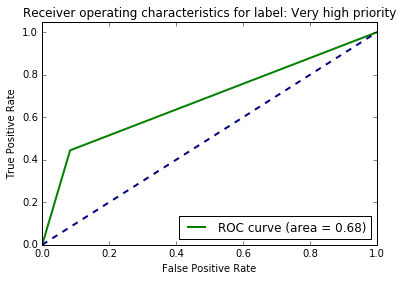

In [46]:
# now plot the 4 roc curves using the calculations
# plot for all the labels

for i in range(n_classes):
    plt.figure()
    lw = 2
    plt.plot(fpr[i], tpr[i], color='green',
             lw=lw, label='ROC curve (area = %0.2f)' % roc_auc[i])
    plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver operating characteristics for label: ' + reverse_labels_mappings[i])
    plt.legend(loc="lower right")
    plt.savefig("../ROC_plots/" + reverse_labels_mappings[i] + ".png")
    plt.show()